In [1]:
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
def extract_face(img, scale_factor=0.5):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    # Resize the image to save memory
    small_img = cv2.resize(img, (0, 0), fx=scale_factor, fy=scale_factor)
    gray = cv2.cvtColor(small_img, cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
    
    # Scale back the coordinates to original size
    if len(faces) > 0:
        (x, y, w, h) = faces[0]
        x, y, w, h = int(x / scale_factor), int(y / scale_factor), int(w / scale_factor), int(h / scale_factor)
        return img[y:y+h, x:x+w]
    else:
        return None


In [3]:
# Define the function to load and process images
def process_image(img_path, label, scale_factor=0.5):
    img = cv2.imread(img_path.decode('utf-8'))
    if img is not None:
        face = extract_face(img, scale_factor=scale_factor)
        if face is not None:
            face = cv2.resize(face, (64, 64))
            return face, tf.cast(label, tf.int64)  # Ensure the label is int64
    return np.zeros((64, 64, 3), dtype=np.uint8), tf.cast(label, tf.int64)  # Ensure the label is int64

# Define function to create the TensorFlow dataset
def create_dataset(data_dir, scale_factor=0.5, batch_size=32, shuffle=True):
    image_paths = []
    labels = []
    for label_name in ["real", "fake"]:
        label_dir = os.path.join(data_dir, label_name)
        for img_name in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_name)
            image_paths.append(img_path)
            labels.append(0 if label_name == "real" else 1)
    
    image_paths = tf.constant(image_paths)
    labels = tf.constant(labels)

    # Create TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda img_path, label: tf.numpy_function(
            process_image, [img_path, label, scale_factor], [tf.uint8, tf.int64]),
            num_parallel_calls=tf.data.AUTOTUNE)
    
    # Explicitly set the shapes for TensorFlow
    dataset = dataset.map(lambda img, lbl: (tf.ensure_shape(img, [64, 64, 3]), tf.ensure_shape(lbl, [])))

    # Set batch, shuffle, and prefetch options
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_paths))
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Paths for training, validation, and testing data
train_data_dir = r"C:\Users\ASUS\Downloads\Deepfake\Dataset\Train"
val_data_dir = r"C:\Users\ASUS\Downloads\Deepfake\Dataset\Validation"
test_data_dir = r"C:\Users\ASUS\Downloads\Deepfake\Dataset\Test"

# Create datasets
train_dataset = create_dataset(train_data_dir)
val_dataset = create_dataset(val_data_dir, shuffle=False)
test_dataset = create_dataset(test_data_dir, shuffle=False)

In [4]:
# Define the discriminator model
def build_discriminator():
    model = models.Sequential([
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=(64, 64, 3)),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize and summarize the model
discriminator = build_discriminator()
discriminator.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 flatten (Flatten)           (None, 32768)             0

In [7]:
history = discriminator.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=2
)
# Save the trained model
discriminator.save('deepfakeclassifier.h5')

Epoch 1/2
4376/4376 [==============================] - 2081s 105ms/step - loss: 1.5805 - accuracy: 0.6973 - val_loss: 2.1483 - val_accuracy: 0.6673
Epoch 2/2
4376/4376 [==============================] - 2137s 108ms/step - loss: 1.5949 - accuracy: 0.7032 - val_loss: 1.2668 - val_accuracy: 0.7183


In [8]:
# Evaluate the model on the test set
test_loss, test_accuracy = discriminator.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.2f}")

341/341 [==============================] - 112s 326ms/step - loss: 1.6474 - accuracy: 0.6408
Test Accuracy: 0.64


1/1 [==============================] - 0s 104ms/step
Classification Report:
               precision    recall  f1-score   support

        Real       0.86      0.33      0.48      5413
        Fake       0.59      0.95      0.73      5492

    accuracy                           0.64     10905
   macro avg       0.73      0.64      0.60     10905
weighted avg       0.72      0.64      0.60     10905



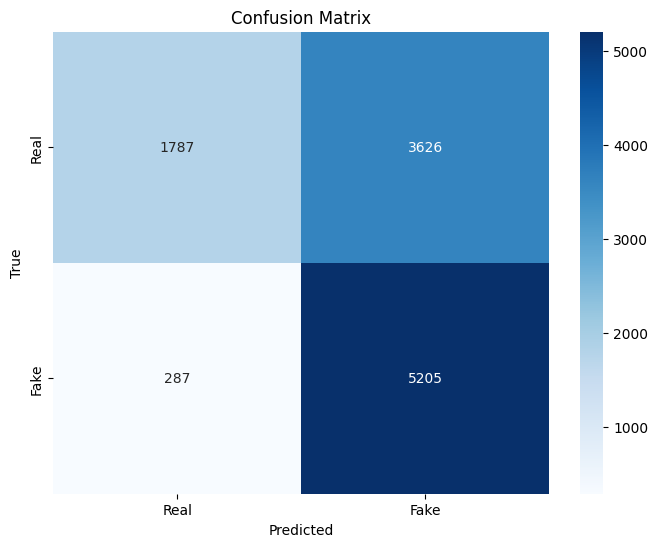

In [9]:
# Predict on test dataset for confusion matrix and classification report
y_pred = []
y_true = []
for images, labels in test_dataset:
    preds = (discriminator.predict(images) > 0.5).astype("int32")
    y_pred.extend(preds.flatten())
    y_true.extend(labels.numpy())

# Calculate confusion matrix and classification report
cm = confusion_matrix(y_true, y_pred)
cr = classification_report(y_true, y_pred, target_names=["Real", "Fake"])

print("Classification Report:\n", cr)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available and TensorFlow is using it.")
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
else:
    print("GPU not detected; check your setup.")

GPU is available and TensorFlow is using it.


1/1 [==============================] - 0s 119ms/step


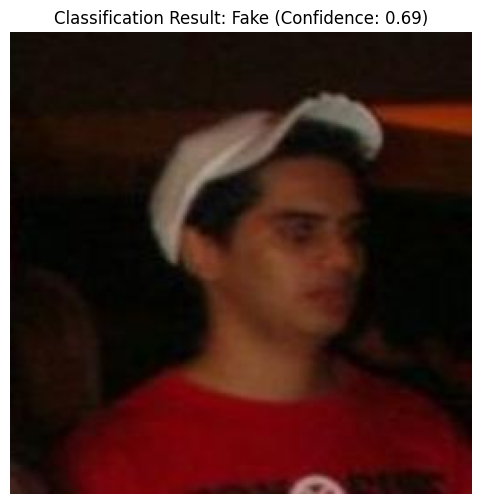

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('deepfakeclassifier.h5')

# Function to preprocess a single image
def preprocess_image(img_path, scale_factor=0.5):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError("Image not found or invalid image path.")
    face = extract_face(img, scale_factor=scale_factor)
    if face is not None:
        face = cv2.resize(face, (64, 64))  # Resize to the input size of the model
        face = face.astype('float32') / 255.0  # Normalize pixel values
        return np.expand_dims(face, axis=0), img  # Add batch dimension, return both original and processed image
    else:
        raise ValueError("No face detected in the image.")

# Function to extract the face
def extract_face(img, scale_factor=0.5):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    small_img = cv2.resize(img, (0, 0), fx=scale_factor, fy=scale_factor)
    gray = cv2.cvtColor(small_img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    if len(faces) > 0:
        (x, y, w, h) = faces[0]
        x, y, w, h = int(x / scale_factor), int(y / scale_factor), int(w / scale_factor), int(h / scale_factor)
        return img[y:y+h, x:x+w]
    return None

# Path to the test image
test_image_path = r"C:\Users\ASUS\Downloads\Deepfake\Dataset\Train\Real\real_9.jpg"  # Replace with your test image path

# Preprocess the image
try:
    processed_image, original_image = preprocess_image(test_image_path)
    
    # Predict the class
    prediction = model.predict(processed_image)
    
    # Interpret the result
    result_text = ""
    if prediction[0] > 0.5:
        result_text = f"Fake (Confidence: {prediction[0][0]:.2f})"
    else:
        result_text = f"Real (Confidence: {1 - prediction[0][0]:.2f})"
    
    # Display the image
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Classification Result: {result_text}")
    plt.axis('off')
    plt.show()
except ValueError as e:
    print(f"Error: {e}")
